In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# 支持中文
plt.rcParams['font.sans-serif'] = ['SimHei']  # 用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号
import warnings
warnings.filterwarnings('ignore')

from sklearn import metrics

In [3]:
origin_data = pd.read_csv("D:\Jupyter_documents\Kaggle_churn\data\Telecom_customer churn.csv")

数据准备

In [4]:
# 由于特征较多，缺失值比例大于3%的特征直接剔除
del_cols = ['ownrent','lor','dwlltype','adults','infobase','income','numbcars','HHstatin','dwllsize',
           'prizm_social_one','hnd_webcap','churn']
target = origin_data['churn']
df = origin_data[[col for col in origin_data.columns.tolist() if col not in del_cols]]
df

,rev_Mean,mou_Mean,totmrc_Mean,da_Mean,ovrmou_Mean,ovrrev_Mean,vceovr_Mean,datovr_Mean,roam_Mean,change_mou,...,forgntvl,ethnic,kid0_2,kid3_5,kid6_10,kid11_15,kid16_17,creditcd,eqpdays,Customer_ID
0,23.9975,219.25,22.500,0.2475,0.00,0.0,0.0,0.0,0.0,-157.25,...,0.0,N,U,U,U,U,U,Y,361.0,1000001
1,57.4925,482.75,37.425,0.2475,22.75,9.1,9.1,0.0,0.0,532.25,...,0.0,Z,U,U,U,U,U,Y,240.0,1000002
2,16.9900,10.25,16.990,0.0000,0.00,0.0,0.0,0.0,0.0,-4.25,...,0.0,N,U,Y,U,U,U,Y,1504.0,1000003
3,38.0000,7.50,38.000,0.0000,0.00,0.0,0.0,0.0,0.0,-1.50,...,0.0,U,Y,U,U,U,U,Y,1812.0,1000004
4,55.2300,570.50,71.980,0.0000,0.00,0.0,0.0,0.0,0.0,38.50,...,0.0,I,U,U,U,U,U,Y,434.0,1000005
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,S,U,U,U,Y,U,Y,773.0,1099996
99996,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,N,U,U,Y,Y,Y,Y,835.0,1099997
99997,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,U,Y,Y,U,U,U,N,433.0,1099998
99998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,S,U,U,U,U,U,N,75.0,1099999


In [5]:
categ_cols = ['months','uniqsubs','actvsubs','new_cell','crclscod','asl_flag','area','dualband','refurb_new',
              'ethnic','kid0_2','kid3_5','kid6_10','kid11_15','kid16_17','creditcd','Customer_ID','marital']
numeric_cols = [col for col in df.columns.tolist() if col not in categ_cols]

In [6]:
# 类别变量用Unknown填充，自成一类
for col in categ_cols:
    if len(df[df[col].isnull()][col]) != 0:
        print('starting filling '+col+'...')
        df[col] = df[col].fillna('Unknown')
        print(col+'  done!')
        
# 这里的填充和训练集测试集的划分无关，因此一并进行填充处理

starting filling area...
area  done!
starting filling dualband...
dualband  done!
starting filling refurb_new...
refurb_new  done!
starting filling ethnic...
ethnic  done!
starting filling kid0_2...
kid0_2  done!
starting filling kid3_5...
kid3_5  done!
starting filling kid6_10...
kid6_10  done!
starting filling kid11_15...
kid11_15  done!
starting filling kid16_17...
kid16_17  done!
starting filling creditcd...
creditcd  done!
starting filling marital...
marital  done!


In [7]:
# 连续变量用lgb方法填充

import lightgbm as lgb

params = {
            'boosting_type': 'gbdt',
            'objective': 'regression',
            'metric': {'rmse'},
            'subsample': 0.4,
            'subsample_freq': 1,
            'learning_rate': 0.3,
            'num_leaves': 40,
            'feature_fraction': 0.75,
            'lambda_l1': 1,
            'lambda_l2': 1
            }

def lgb_fillna(colname):
    
    df_temp = df[numeric_cols]
    te = df_temp[df_temp[colname].notnull()] # 非空的该列对应的行
    te_X = te[[col for col in numeric_cols if col!=colname]]
    te_Y = te[colname]
    te_X = te_X.astype(float)
    te_Y = te_Y.astype(float)
    
    tr = df_temp[df_temp[colname].isnull()]
    tr_X = tr[[col for col in numeric_cols if col!=colname]]
    tr_Y = tr[colname]
    tr_X = tr_X.astype(float)
    tr_Y = tr_Y.astype(float)
    lgb_train = lgb.Dataset(te_X, te_Y)
    gbm = lgb.train(params,lgb_train)
    pr = gbm.predict(tr_X)
    
    # 赋值
    df.loc[df[colname].isnull(), colname] = list(pr)

In [8]:
for col in numeric_cols:
    if len(df[df[col].isnull()][col]) != 0:
        print('starting filling '+col+'...')
        lgb_fillna(col)
        print(col+'  done!')

starting filling rev_Mean...
rev_Mean  done!
starting filling mou_Mean...
mou_Mean  done!
starting filling totmrc_Mean...
totmrc_Mean  done!
starting filling da_Mean...
da_Mean  done!
starting filling ovrmou_Mean...
ovrmou_Mean  done!
starting filling ovrrev_Mean...
ovrrev_Mean  done!
starting filling vceovr_Mean...
vceovr_Mean  done!
starting filling datovr_Mean...
datovr_Mean  done!
starting filling roam_Mean...
roam_Mean  done!
starting filling change_mou...
change_mou  done!
starting filling change_rev...
change_rev  done!
starting filling avg6mou...
avg6mou  done!
starting filling avg6qty...
avg6qty  done!
starting filling avg6rev...
avg6rev  done!
starting filling hnd_price...
hnd_price  done!
starting filling phones...
phones  done!
starting filling models...
models  done!
starting filling truck...
truck  done!
starting filling rv...
rv  done!
starting filling forgntvl...
forgntvl  done!
starting filling eqpdays...
eqpdays  done!


In [9]:
# 缺失值填充完成
df

,rev_Mean,mou_Mean,totmrc_Mean,da_Mean,ovrmou_Mean,ovrrev_Mean,vceovr_Mean,datovr_Mean,roam_Mean,change_mou,...,forgntvl,ethnic,kid0_2,kid3_5,kid6_10,kid11_15,kid16_17,creditcd,eqpdays,Customer_ID
0,23.997500,219.250000,22.500000,0.247500,0.000000,0.000000,0.000000,0.000000,0.000000,-157.250000,...,0.0,N,U,U,U,U,U,Y,361.0,1000001
1,57.492500,482.750000,37.425000,0.247500,22.750000,9.100000,9.100000,0.000000,0.000000,532.250000,...,0.0,Z,U,U,U,U,U,Y,240.0,1000002
2,16.990000,10.250000,16.990000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-4.250000,...,0.0,N,U,Y,U,U,U,Y,1504.0,1000003
3,38.000000,7.500000,38.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.500000,...,0.0,U,Y,U,U,U,U,Y,1812.0,1000004
4,55.230000,570.500000,71.980000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,38.500000,...,0.0,I,U,U,U,U,U,Y,434.0,1000005
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,4.759148,121.999310,3.293338,0.184179,1.797537,0.119844,-0.364468,0.047131,-0.921200,-123.090877,...,0.0,S,U,U,U,Y,U,Y,773.0,1099996
99996,17.010609,377.778818,18.036193,0.786393,1.797537,0.105727,-0.364468,0.047131,-4.752467,-19.924987,...,0.0,N,U,U,Y,Y,Y,Y,835.0,1099997
99997,3.346619,210.887722,3.146813,0.233533,1.797537,0.105727,-0.090344,0.055458,1.486890,-354.436891,...,0.0,U,Y,Y,U,U,U,N,433.0,1099998
99998,86.460559,556.754584,82.807359,1.688719,-1.176898,-0.297388,0.300239,1.020286,0.507658,-391.804407,...,0.0,S,U,U,U,U,U,N,75.0,1099999


In [10]:
# 训练集测试集的划分
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(df, target, test_size = 0.3)
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(70000, 88)
(30000, 88)
(70000,)
(30000,)


In [ ]:
# 对类别变量进行编码
from sklearn import preprocessing
le = preprocessing.LabelEncoder()


In [11]:
x_all_train = x_train[numeric_cols]
x_all_test = x_test[numeric_cols]
y_all_train = y_train
y_all_test = y_test

神经网络

In [24]:
import tensorflow as tf

num_classes = 1 # 输出大小
input_size = 70 # 输入大小
hidden_units_size = 10 # 隐藏层节点个数
learning_rate = 0.001
scale = 0.1
batch_size = 1000
training_iterations = 10000

X = tf.placeholder(tf.float32, shape=[None, input_size])
Y = tf.placeholder(tf.float32, shape=[None, num_classes])

W1 = tf.Variable(tf.random_normal([input_size, hidden_units_size], stddev=0.1))
B1 = tf.Variable(tf.constant(0.1), [hidden_units_size])
W2 = tf.Variable(tf.random_normal([hidden_units_size, num_classes], stddev=0.1))
B2 = tf.Variable(tf.constant(0.1), [num_classes])

hidden_opt = tf.matmul(X, W1)+B1 # 输入层到隐藏层正向传播
hidden_opt = tf.nn.relu(hidden_opt) # 激活函数，用于计算节点输出值
final_opt = tf.nn.sigmoid(tf.matmul(hidden_opt, W2)+B2) # 隐藏层到输出层正向传播

# 添加正则项
tf.add_to_collection(tf.GraphKeys.WEIGHTS, W1)
tf.add_to_collection(tf.GraphKeys.WEIGHTS, B1)
tf.add_to_collection(tf.GraphKeys.WEIGHTS, W2)
tf.add_to_collection(tf.GraphKeys.WEIGHTS, B2)
regularizer = tf.contrib.layers.l2_regularizer(scale)
reg_term = tf.contrib.layers.apply_regularization(regularizer)
# 对输出层计算交叉熵损失
loss = -tf.reduce_mean(Y*tf.log(tf.clip_by_value(final_opt,1e-10,1.0))+(1-Y)*tf.log(tf.clip_by_value(1-final_opt,1e-10,1.0)))+reg_term
# 梯度下降算法，这里使用反向传播算法用于修改权重，减小损失
opt = tf.train.AdamOptimizer(learning_rate).minimize(loss)
# 初始化变量
init = tf.global_variables_initializer()

# 创建会话运行Tensorflow程序
sess = tf.Session()
sess.run(init)
for i in range(training_iterations):
    # 每次选取batch_size个样本进行训练
    start = (i*batch_size)%70000
    end = min(start+batch_size, 70000)
    batch_input = x_all_train[start:end]
    batch_labels = np.array(y_all_train[start:end]).reshape(batch_size,1)
    # 训练
    training_loss = sess.run([opt, loss], feed_dict={X:batch_input, Y:batch_labels})
    if i % 1000 == 0:
        total_cross_entropy = sess.run(loss, feed_dict={X:x_all_train, Y:np.array(y_all_train).reshape(70000,1)})
        print("step:%d, total_cross entropy=%g"%(i, total_cross_entropy))

step:0, total_cross entropy=11.8381
step:1000, total_cross entropy=0.902886
step:2000, total_cross entropy=0.817892
step:3000, total_cross entropy=1.47291
step:4000, total_cross entropy=0.844093
step:5000, total_cross entropy=0.773708
step:6000, total_cross entropy=1.01353
step:7000, total_cross entropy=0.726154
step:8000, total_cross entropy=0.738647
step:9000, total_cross entropy=0.725148


In [25]:
# 输出权重值
#print(sess.run(B1))
#print(sess.run(W2))

训练集评估

In [26]:
# 对输出层计算各项分类评价指标
pred_Y = sess.run(final_opt, feed_dict={X:x_all_train})
for i in range(len(pred_Y)):
    if pred_Y[i]>=0.5:
        pred_Y[i] = 1
    else:
        pred_Y[i] = 0

Precision 0.5243392653005511
Recall 0.884141780309569
f1_score 0.658283976137179
confusion_matrix
[[ 7364 27878]
 [ 4027 30731]]


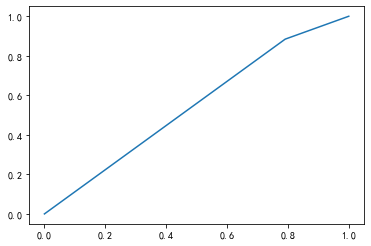

In [27]:

print("Precision", metrics.precision_score(y_all_train, pred_Y))
print("Recall", metrics.recall_score(y_all_train, pred_Y))
print("f1_score", metrics.f1_score(y_all_train, pred_Y))
print("confusion_matrix")
print(metrics.confusion_matrix(y_all_train, pred_Y))
fpr, tpr, tresholds = metrics.roc_curve(y_all_train, pred_Y)
plt.plot(fpr, tpr)

测试集评估

Precision 0.5195267218291562
Recall 0.8779383950283707
f1_score 0.6527711509002788
confusion_matrix
[[ 3176 12020]
 [ 1807 12997]]


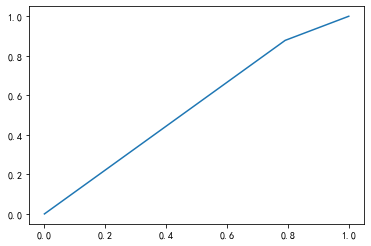

In [28]:
# 对输出层计算各项分类评价指标
pred_Y = sess.run(final_opt, feed_dict={X:x_all_test})
for i in range(len(pred_Y)):
    if pred_Y[i]>=0.5:
        pred_Y[i] = 1
    else:
        pred_Y[i] = 0
        
print("Precision", metrics.precision_score(y_all_test, pred_Y))
print("Recall", metrics.recall_score(y_all_test, pred_Y))
print("f1_score", metrics.f1_score(y_all_test, pred_Y))
print("confusion_matrix")
print(metrics.confusion_matrix(y_all_test, pred_Y))
fpr, tpr, tresholds = metrics.roc_curve(y_all_test, pred_Y)
plt.plot(fpr, tpr)

随机森林

In [13]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier()
rf.fit(x_all_train, y_all_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [15]:
pred_Y = rf.predict(x_all_test)

Precision 0.5785026195707285
Recall 0.46066886481394254
f1_score 0.5129050383967035
confusion_matrix
[[10151  4988]
 [ 8015  6846]]


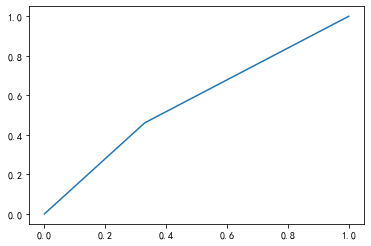

In [16]:
print("Precision", metrics.precision_score(y_all_test, pred_Y))
print("Recall", metrics.recall_score(y_all_test, pred_Y))
print("f1_score", metrics.f1_score(y_all_test, pred_Y))
print("confusion_matrix")
print(metrics.confusion_matrix(y_all_test, pred_Y))
fpr, tpr, tresholds = metrics.roc_curve(y_all_test, pred_Y)
plt.plot(fpr, tpr)